# Toy Correlation Tutorial

In this notebook, we demonstrate how to use the toolkit to implement errors-on-error in a combination scenario, under different correlation assumptions.

In the first part of this tutorial, we focus on a simple combination of two measurements. Both measurements estimate the same physical quantity, with central values \( y_1 = 1.5 \) and \( y_2 = -1.5 \), and statistical uncertainties \( \sigma_{y_1} = \sigma_{y_2} = 1 \). We introduce a single systematic source with magnitudes \( \Gamma_1 = 0.5 \) and \( \Gamma_2 = 1 \), such that the first measurement carries a smaller total uncertainty.

We begin by setting all error-on-error terms to zero, so that only the correlation structure influences the result. We then show how to introduce and incorporate the effect of errors-on-error in the combination.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm
from copy import deepcopy

script_dir = os.getcwd()
gvm_root = os.path.abspath(os.path.join(script_dir, "../../"))
if gvm_root not in sys.path:
    sys.path.insert(0, gvm_root)

from gvm_toolkit import GVMCombination

# No errors-on-errors

## 1. Systematic correlation examples

We now compare three different correlation matrices for the systematic uncertainty:
1. **Diagonal**: off-diagonal terms are zero so the systematic acts independently.
2. **Hybrid**: the off-diagonal coefficient is 0.75 representing a partial correlation.
3. **Fully correlated**: all coefficients are one so the systematic behaves as one shared nuisance parameter.

In the configuration file, errors-on-error are explicitly set to zero, and their type is set to *dependent*. In principle, one could omit both the error-on-error value and its type, since the defaults are zero and *dependent*, respectively. Note that the systematic type is irrelevant when the error-on-error is zero.

The following cells build a `GVMCombination` for each correlation scenario. After running the fit we print the estimated mean (`mu_hat`), the 68% confidence interval and the goodness-of-fit (chi-square) value.

In [2]:
comb = GVMCombination('input_files/diag_corr.yaml')
mu_hat = comb.fit_results['mu']
ci_low, ci_high, _ = comb.confidence_interval()
chi_2 = comb.goodness_of_fit()
p_value = 1 - chi2.cdf(chi_2, df=1)
significance = norm.ppf(1 - p_value/2)
print('Diagonal')
print(f'mu_hat = {mu_hat:.4f}, CI = ({ci_low:.4f}, {ci_high:.4f})')
print(f'χ² = {chi_2:.3f}, significance = {significance} \n')

comb = GVMCombination('input_files/hybrid_corr.yaml')
mu_hat = comb.fit_results['mu']
ci_low, ci_high, _ = comb.confidence_interval()
chi_2 = comb.goodness_of_fit()
p_value = 1 - chi2.cdf(chi_2, df=1)
significance = norm.ppf(1 - p_value/2)
print('Hybrid correlation')
print(f'mu_hat = {mu_hat:.4f}, CI = ({ci_low:.4f}, {ci_high:.4f})')
print(f'χ² = {chi_2:.3f}, significance = {significance} \n')

comb = GVMCombination('input_files/full_corr.yaml')
mu_hat = comb.fit_results['mu']
ci_low, ci_high, _ = comb.confidence_interval()
chi_2 = comb.goodness_of_fit()
p_value = 1 - chi2.cdf(chi_2, df=1)
significance = norm.ppf(1 - p_value/2)
print('Fully correlated')
print(f'mu_hat = {mu_hat:.4f}, CI = ({ci_low:.4f}, {ci_high:.4f})')
print(f'χ² = {chi_2:.3f}, significance = {significance}')

Diagonal
mu_hat = 0.3462, CI = (-0.5332, 1.2230)
χ² = 2.769, significance = 1.6641005886756863 

Hybrid correlation
mu_hat = 0.4500, CI = (-0.5288, 1.4212)
χ² = 3.600, significance = 1.8973665961010266 

Fully correlated
mu_hat = 0.5000, CI = (-0.5000, 1.5003)
χ² = 4.000, significance = 1.999999999999998


## 2. Non-diagonal statistical covariance
The same systematic is fully correlated as above, but this time the statistical uncertainties are specified via a covariance matrix that includes non-zero off-diagonal terms.

Unlike systematic uncertainties — which can be described through correlation matrices — statistical uncertainties must be provided directly as a **covariance matrix**.

In [3]:
comb = GVMCombination('input_files/stat_cov.yaml')
mu_hat = comb.fit_results['mu']
ci_low, ci_high, _ = comb.confidence_interval()
chi_2 = comb.goodness_of_fit()
p_value = 1 - chi2.cdf(chi_2, df=1)
significance = norm.ppf(1 - p_value/2)
print(f'mu_hat = {mu_hat:.4f}, CI = ({ci_low:.4f}, {ci_high:.4f})')
print(f'χ² = {chi_2:.3f}, significance = {significance}')


mu_hat = 0.5000, CI = (-0.9187, 1.9138)
χ² = 4.000, significance = 1.999999999999998


## 3. Tip: modifying the combination
You can obtain the current input with `input_data()` and modify the returned dictionary. 
After editing, pass it to `update_data()` to apply the changes before refitting.


In [5]:
comb = GVMCombination('input_files/diag_corr.yaml')

# extract current configuration
info = comb.input_data()

# change measurement and systematic values
info['data']['measurements']['m1']['central'] = 2.0
info['syst']['sys1']['shift']['value']['m1'] = 0.5

# update the systematic to be dependent with a new correlation matrix
info['syst']['sys1']['error-on-error']['type'] = 'dependent'
info['syst']['sys1']['shift']['correlation'] = np.array([[1.0, 0.3], [0.3, 1.0]])

# apply modifications and refit
comb.update_data(info)
comb.fit_results = comb.minimize()
print(f"updated mu_hat={comb.fit_results['mu']:.4f}")


updated mu_hat=0.6949


# Effect of error-on-error

We now vary the error-on-error parameter ($\varepsilon$) from 0 to 0.6 to illustrate how the combination results depend on its value. When errors-on-error are nonzero, the distinction between *independent* and *dependent* systematics becomes relevant and affects the outcome of the combination.

- When a systematic effect is **independent**, the estimates of the systematic uncertainties for the measurements in the combination are statistically independent. This means that the systematic uncertainty for measurement *m1* could be overestimated while *m2* is underestimated, or vice versa — both estimates can fluctuate independently. This also implies that the correlation matrix of the corresponding nuisance parameters must be diagonal. If a non-diagonal correlation matrix is provided, the toolkit will raise an error.

- When a systematic effect is **dependent**, the estimates of the systematic uncertainties are statistically dependent. In this case, if one estimate is overestimated, the other must be as well, and vice versa. This situation may arise, for example, when uncorrelated systematic effects are estimated using similar techniques. A typical LHC example is a two-point systematic derived from comparing HERWIG and PYTHIA. When the **dependent** type is used, an arbitrary correlation matrix can be provided for the given systematic.

More details on how to implement errors-on-errors in combinations can be found in Sec. 3 of [arXiv:2407.05322](https://arxiv.org/abs/2407.05322), with a more in-depth explanation of dependent vs. independent assumptions in Sec. 3.2.

## 1. Independent systematic
 

### Compatible Measurements
Here, we reinitialize the combination using the configuration file `diag_corr.yaml` as a starting point. In the first example, we examine how the results change when the input measurements are compatible. The systematic type must be changed to *independent*, since the configuration file sets it to *dependent*.

In [21]:
eps_grid = np.linspace(0., 0.6, 14)
comb = GVMCombination('input_files/diag_corr.yaml')

base_info = comb.input_data()

y_1 = base_info['data']['measurements']['m1']['central']
y_2 = base_info['data']['measurements']['m2']['central']
base_info['syst']['sys1']['error-on-error']['type'] = 'independent'

comb.update_data(base_info)

cv = []
lower_bound = []
upper_bound = []
ci = []

sign = []

for eps in eps_grid:
    base_info = deepcopy(base_info)
    base_info['syst']['sys1']['error-on-error']['value'] = float(eps)
    comb.update_data(base_info)
    cv.append(comb.fit_results['mu'])
    lower_bound.append(comb.confidence_interval()[0])
    upper_bound.append(comb.confidence_interval()[1])
    ci.append(comb.confidence_interval()[2])
    
    chi_2 = comb.goodness_of_fit()
    p_value = 1 - chi2.cdf(chi_2, df=1)
    sign_eps = norm.ppf(1 - p_value/2)
    sign.append(sign_eps)

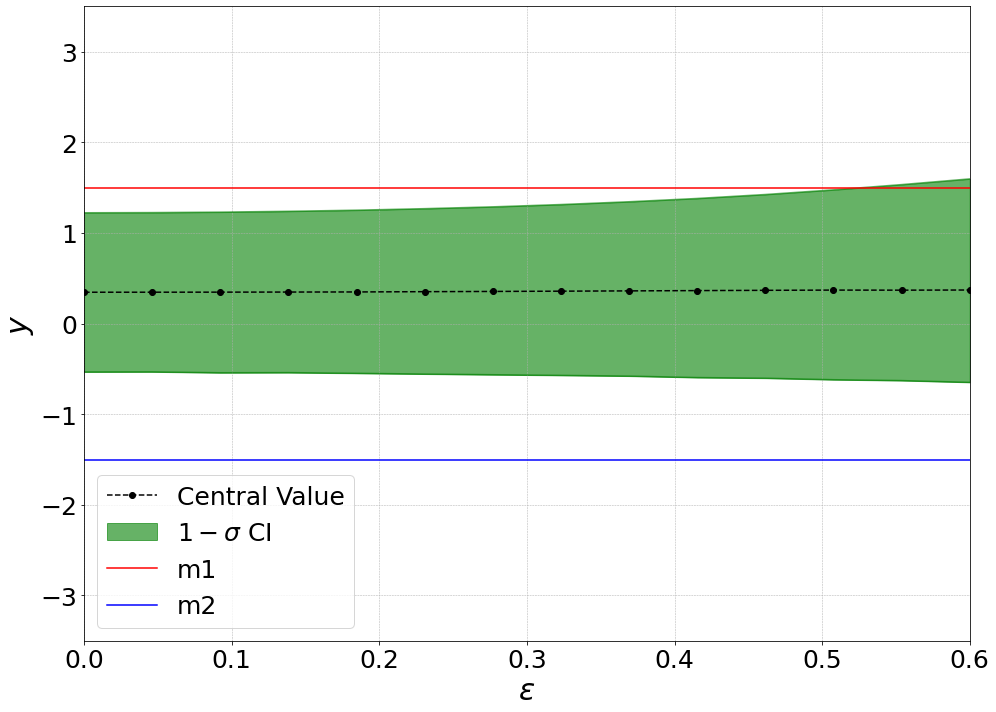

In [22]:
plt.figure(figsize=(14, 10))

# Plot central value: dashed line with circle markers
plt.plot(eps_grid, cv, color="black", marker='o', linestyle="--", label="Central Value")

# Plot the 1-sigma confidence interval boundaries and fill-between
plt.plot(eps_grid, upper_bound, color="green", alpha=0.6)
plt.plot(eps_grid, lower_bound, color="green", alpha=0.6)
plt.fill_between(eps_grid, upper_bound, lower_bound, color='green', alpha=0.6, label="$1-\sigma$ CI")

# Plot horizontal reference lines
plt.axhline(y_1, color='r', linestyle='-', label="m1")
plt.axhline(y_2, color='b', linestyle='-', label="m2")

plt.xlabel("$\epsilon$", fontsize=30)
plt.ylabel("$y$", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, loc = 'lower left')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

plt.ylim(-3.5, 3.5)
plt.xlim(0.0, 0.6)

plt.savefig("output/independent_compatible.png")
plt.show()

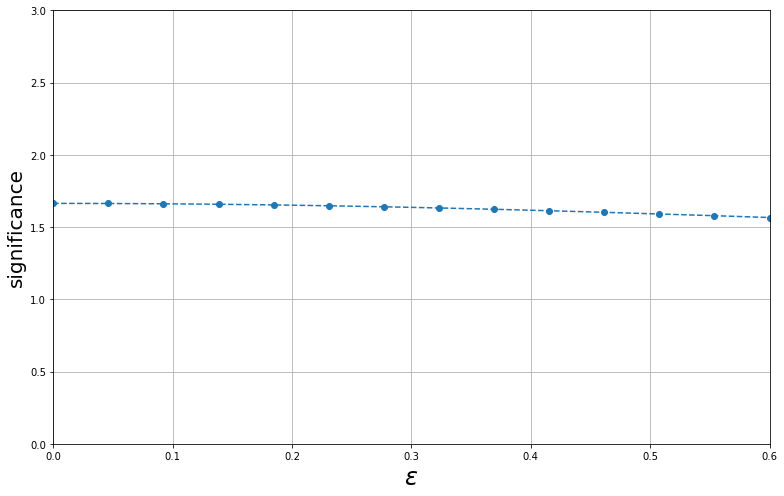

In [23]:
plt.figure(figsize=(11, 7))
plt.plot(eps_grid, sign, '--o')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel(r'significance', fontsize=20)
plt.ylim((0.0, 3))
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.tight_layout()
plt.savefig('output/independent_compatible_gof.png')
plt.show()

In general, when the input measurements are compatible, the results are only slightly affected by errors-on-errors. Specifically:

1. The **confidence interval** slightly widens as $\varepsilon$ increases. Furthermore, the growth occurs more prominently toward the more precise of the two measurements, "m1".

2. The **goodness-of-fit** slightly decreases with increasing $\varepsilon$.

### Incompatible Measurements

Here, we set \( y_1 = 2.5 \) and \( y_2 = -2.5 \) to illustrate how errors-on-errors affect the result of the average.

In [24]:
eps_grid = np.linspace(0., 0.6, 14)
comb = GVMCombination('input_files/diag_corr.yaml')

base_info = comb.input_data()
cv = []

y_1 = 2.5
y_2 = -2.5
base_info['data']['measurements']['m1']['central'] = y_1
base_info['data']['measurements']['m2']['central'] = y_2
base_info['syst']['sys1']['error-on-error']['type'] = 'independent'

comb.update_data(base_info)

lower_bound = []
upper_bound = []
ci = []

sign = []

for eps in eps_grid:
    base_info = deepcopy(base_info)
    base_info['syst']['sys1']['error-on-error']['value'] = float(eps)
    comb.update_data(base_info)
    cv.append(comb.fit_results['mu'])
    lower_bound.append(comb.confidence_interval()[0])
    upper_bound.append(comb.confidence_interval()[1])
    ci.append(comb.confidence_interval()[2])
    
    chi_2 = comb.goodness_of_fit()
    p_value = 1 - chi2.cdf(chi_2, df=1)
    sign_eps = norm.ppf(1 - p_value/2)
    sign.append(sign_eps)

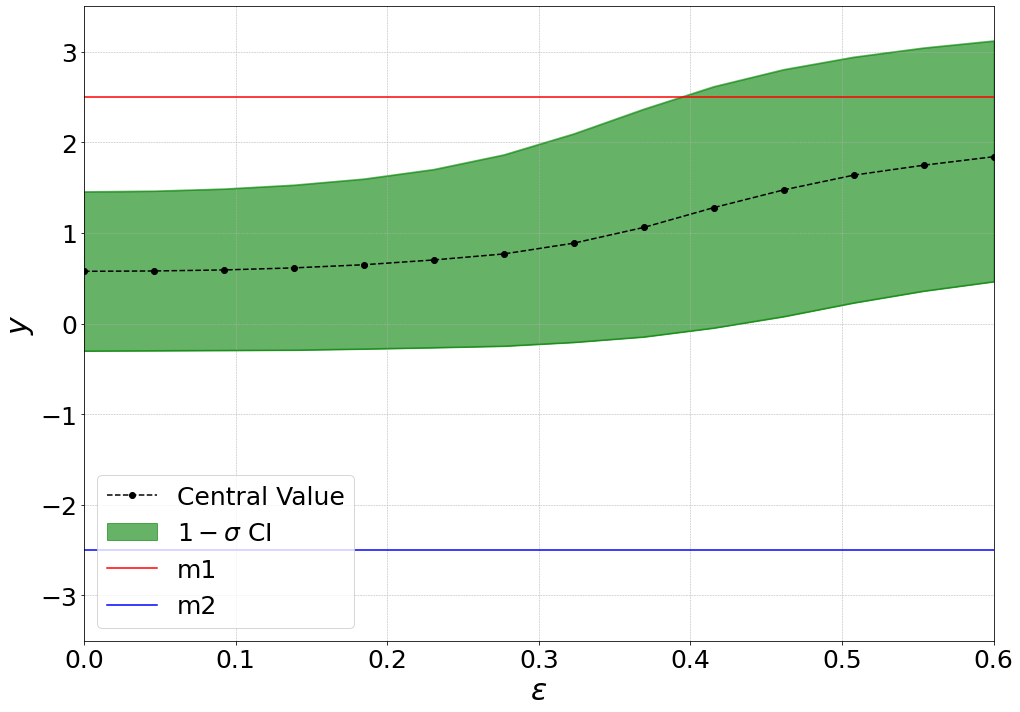

In [25]:
plt.figure(figsize=(14, 10))

# Plot central value: dashed line with circle markers
plt.plot(eps_grid, cv, color="black", marker='o', linestyle="--", label="Central Value")

# Plot the 1-sigma confidence interval boundaries and fill-between
plt.plot(eps_grid, upper_bound, color="green", alpha=0.6)
plt.plot(eps_grid, lower_bound, color="green", alpha=0.6)
plt.fill_between(eps_grid, upper_bound, lower_bound, color='green', alpha=0.6, label="$1-\sigma$ CI")

# Plot horizontal reference lines
plt.axhline(y_1, color='r', linestyle='-', label="m1")
plt.axhline(y_2, color='b', linestyle='-', label="m2")

plt.xlabel("$\epsilon$", fontsize=30)
plt.ylabel("$y$", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, loc = 'lower left')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

plt.ylim(-3.5, 3.5)
plt.xlim(0.0, 0.6)

plt.savefig("output/independent_incompatible.png")
plt.show()

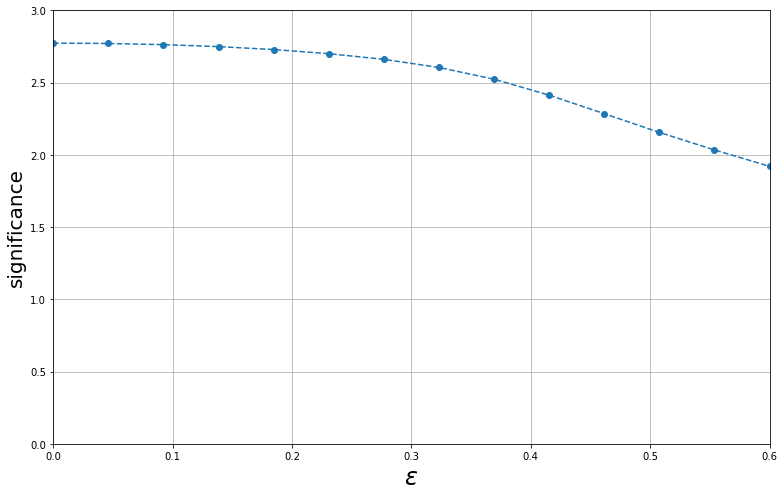

In [26]:
plt.figure(figsize=(11, 7))
plt.plot(eps_grid, sign, '--o')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel(r'significance', fontsize=20)
plt.ylim((0.0, 3))
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.tight_layout()
plt.savefig('output/independent_incompatible_gof.png')
plt.show()

When the degree of incompatibility between the input data is larger, three effects can be observed as $\varepsilon$ increases:

1. The central value shifts toward the more precise measurement.

2. The confidence interval widens.

3. The goodness-of-fit decreases.

## 2. Dependent systematic

Here, we focus exclusively on the case where the input measurements are in mutual tension. In the case of compatible measurements, errors-on-errors would once again have little to no effect.

In [27]:
eps_grid = np.linspace(0., 0.6, 14)
comb = GVMCombination('input_files/diag_corr.yaml')

base_info = comb.input_data()
cv = []

y_1 = 2.5
y_2 = -2.5
base_info['data']['measurements']['m1']['central'] = y_1
base_info['data']['measurements']['m2']['central'] = y_2
comb.update_data(base_info)

lower_bound = []
upper_bound = []
ci = []

sign = []

for eps in eps_grid:
    base_info = deepcopy(base_info)
    base_info['syst']['sys1']['error-on-error']['value'] = float(eps)
    comb.update_data(base_info)
    cv.append(comb.fit_results['mu'])
    lower_bound.append(comb.confidence_interval()[0])
    upper_bound.append(comb.confidence_interval()[1])
    ci.append(comb.confidence_interval()[2])
    
    chi_2 = comb.goodness_of_fit()
    p_value = 1 - chi2.cdf(chi_2, df=1)
    sign_eps = norm.ppf(1 - p_value/2)
    sign.append(sign_eps)

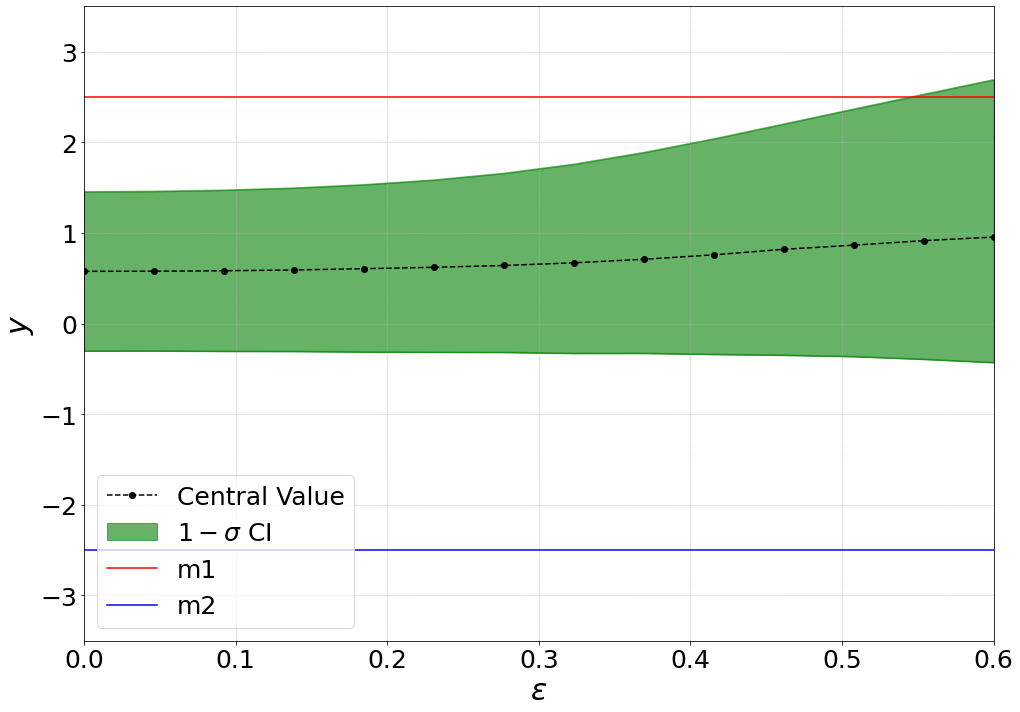

In [28]:
plt.figure(figsize=(14, 10))

# Plot central value: dashed line with circle markers
plt.plot(eps_grid, cv, color="black", marker='o', linestyle="--", label="Central Value")

# Plot the 1-sigma confidence interval boundaries and fill-between
plt.plot(eps_grid, upper_bound, color="green", alpha=0.6)
plt.plot(eps_grid, lower_bound, color="green", alpha=0.6)
plt.fill_between(eps_grid, upper_bound, lower_bound, color='green', alpha=0.6, label="$1-\sigma$ CI")

# Plot horizontal reference lines
plt.axhline(y_1, color='r', linestyle='-', label="m1")
plt.axhline(y_2, color='b', linestyle='-', label="m2")

plt.xlabel("$\epsilon$", fontsize=30)
plt.ylabel("$y$", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, loc = 'lower left')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

plt.ylim(-3.5, 3.5)
plt.xlim(0.0, 0.6)

plt.savefig("output/diagonal.png")
plt.show()

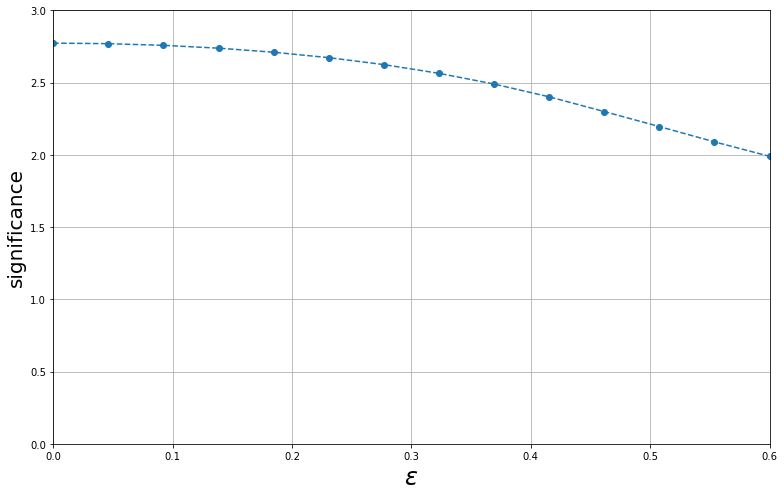

In [29]:
plt.figure(figsize=(11, 7))
plt.plot(eps_grid, sign, '--o')
plt.xlabel(r'$\epsilon$', fontsize=24)
plt.ylabel(r'significance', fontsize=20)
plt.ylim((0.0, 3))
plt.xlim((0.0, 0.6))
plt.grid(True)
plt.tight_layout()
plt.savefig("output/diagonal_gof.png")
plt.show()

This example shows that, while the case with a diagonal correlation matrix and non-zero errors-on-errors is similar to the decorrelated case, it is not identical. In particular, when a diagonal correlation matrix is used, the central value of the combination is more stable and tends to shift less.

## 3. Hybrid correlation

For completeness, we show the results for the two remaining examples: a systematic uncertainty with a correlation coefficient of $0.75$, and a fully correlated one.

In [30]:
eps_grid = np.linspace(0., 0.6, 14)
comb = GVMCombination('input_files/hybrid_corr.yaml')

base_info = comb.input_data()
cv = []

y_1 = 2.5
y_2 = -2.5
base_info['data']['measurements']['m1']['central'] = y_1
base_info['data']['measurements']['m2']['central'] = y_2
comb.update_data(base_info)

lower_bound = []
upper_bound = []
ci = []

sign = []

for eps in eps_grid:
    base_info = deepcopy(base_info)
    base_info['syst']['sys1']['error-on-error']['value'] = float(eps)
    comb.update_data(base_info)
    cv.append(comb.fit_results['mu'])
    lower_bound.append(comb.confidence_interval()[0])
    upper_bound.append(comb.confidence_interval()[1])
    ci.append(comb.confidence_interval()[2])
    
    chi_2 = comb.goodness_of_fit()
    p_value = 1 - chi2.cdf(chi_2, df=1)
    sign_eps = norm.ppf(1 - p_value/2)
    sign.append(sign_eps)

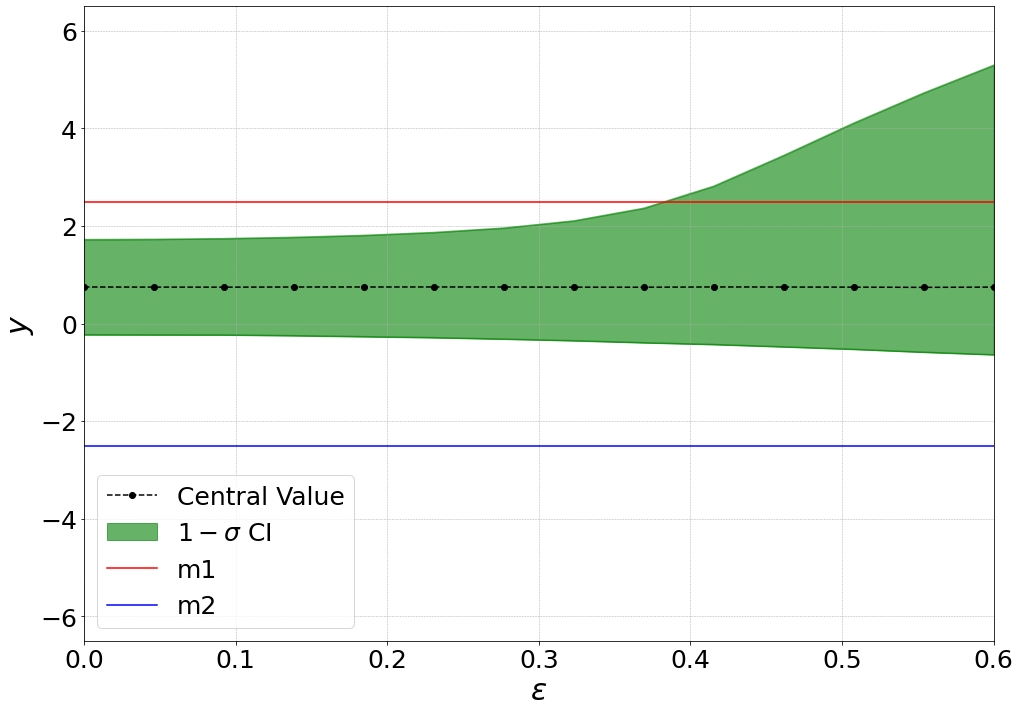

In [31]:
plt.figure(figsize=(14, 10))

# Plot central value: dashed line with circle markers
plt.plot(eps_grid, cv, color="black", marker='o', linestyle="--", label="Central Value")

# Plot the 1-sigma confidence interval boundaries and fill-between
plt.plot(eps_grid, upper_bound, color="green", alpha=0.6)
plt.plot(eps_grid, lower_bound, color="green", alpha=0.6)
plt.fill_between(eps_grid, upper_bound, lower_bound, color='green', alpha=0.6, label="$1-\sigma$ CI")

# Plot horizontal reference lines
plt.axhline(y_1, color='r', linestyle='-', label="m1")
plt.axhline(y_2, color='b', linestyle='-', label="m2")

plt.xlabel("$\epsilon$", fontsize=30)
plt.ylabel("$y$", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, loc = 'lower left')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

plt.ylim(-6.5, 6.5)
plt.xlim(0.0, 0.6)

plt.savefig("output/hybrid.png")
plt.show()

## 4. Fully correlated

In [32]:
eps_grid = np.linspace(0., 0.6, 14)
comb = GVMCombination('input_files/full_corr.yaml')

base_info = comb.input_data()
cv = []

y_1 = 2.5
y_2 = -2.5
base_info['data']['measurements']['m1']['central'] = y_1
base_info['data']['measurements']['m2']['central'] = y_2
comb.update_data(base_info)

lower_bound = []
upper_bound = []
ci = []

sign = []

for eps in eps_grid:
    base_info = deepcopy(base_info)
    base_info['syst']['sys1']['error-on-error']['value'] = float(eps)
    comb.update_data(base_info)
    cv.append(comb.fit_results['mu'])  
    lower_bound.append(comb.confidence_interval()[0])
    upper_bound.append(comb.confidence_interval()[1])
    ci.append(comb.confidence_interval()[2])
    
    chi_2 = comb.goodness_of_fit()
    p_value = 1 - chi2.cdf(chi_2, df=1)
    sign_eps = norm.ppf(1 - p_value/2)
    sign.append(sign_eps)

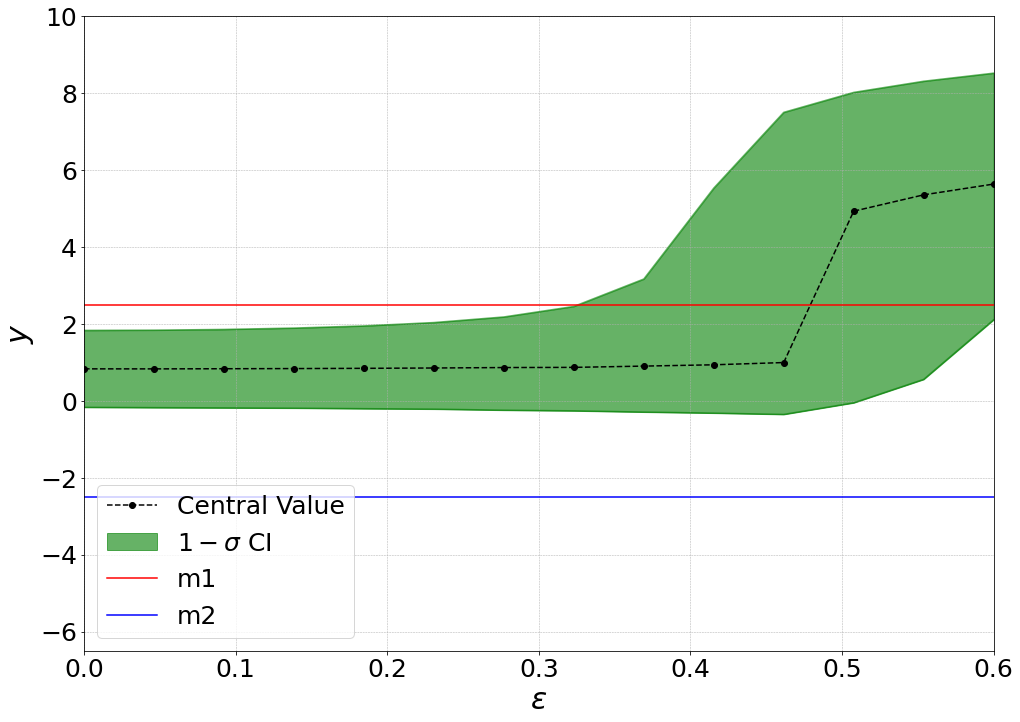

In [33]:
plt.figure(figsize=(14, 10))

# Plot central value: dashed line with circle markers
plt.plot(eps_grid, cv, color="black", marker='o', linestyle="--", label="Central Value")

# Plot the 1-sigma confidence interval boundaries and fill-between
plt.plot(eps_grid, upper_bound, color="green", alpha=0.6)
plt.plot(eps_grid, lower_bound, color="green", alpha=0.6)
plt.fill_between(eps_grid, upper_bound, lower_bound, color='green', alpha=0.6, label="$1-\sigma$ CI")

# Plot horizontal reference lines
plt.axhline(y_1, color='r', linestyle='-', label="m1")
plt.axhline(y_2, color='b', linestyle='-', label="m2")

plt.xlabel("$\epsilon$", fontsize=30)
plt.ylabel("$y$", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, loc = 'lower left')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

plt.ylim(-6.5, 10)
plt.xlim(0.0, 0.6)

plt.savefig("output/fully_corr.png")
plt.show()

This example represents a pathological case, illustrating how, when the error-on-error is large and the systematic uncertainty is fully correlated, the model tends to saturate one of the quadratic terms in the likelihood. In practice, this results in setting the corresponding term to a value close to zero and fully absorbing the internal tension between *m1* and *m2* within the logarithmic systematic constraint of the likelihood.

In general, this highlights that a large error-on-error for this systematic is pathological. The imprecise knowledge of the systematic effect poses a serious problem, rendering the averaging of the two measurements meaningless.

Furthermore, in more realistic combinations involving additional measurements and multiple systematic uncertainties, such pathological behaviours are expected to be less common, as demonstrated in the top-mass tutorial.
